$\mathbf{Fast \ Fourier \ Transform}$ 

FFT transforms a signal from its time representation into the frequency domain by sampling data at fixed intervals and decomposing it into different frequencies. 

This algorithm recovers clusters by propagating waves through a graph. How does it use FFT on the local components. How does this work as a distributed system?


In [19]:
import numpy as np
from lib.spectral_clustering import similarity_matrix, laplacian_matrix, spectral_clustering
from lib.datasets import gaussian_mixture as gm
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
import scipy.fftpack
import scipy.signal

# Building Our Functions to Cluster with the Wave Equation

In [26]:
def array_to_binary(row):
    '''
    This function takes a row of 0's and 1's and turns it into binary, 
    backwards, so [0, 0, 1] becomes 4 
    '''
    binary_to_decimal = 0
    for i in range(len(row)):
        binary_to_decimal += row[i] * 2 ** i
    return binary_to_decimal

def cluster_wave_eq(k, T_max, num_nodes, c, normalized_laplacian):
    '''
    k = number of eigenvectors used, maybe??? < 2**k clusters
    T_max = number of iterations in time
    num_nodes = number of nodes in our graph
    c = constant in the wave equation. 0 < c < sqrt(2) for stability
    normalized_laplacian = D**{-1}L
    '''
    # initialize heat matrix: each row corresponds to a node, column corresponds to a step in time
    heat = np.zeros(shape = (num_nodes, T_max + 1)) #offset index by 1 because we need index -1, evolves with time
    #print(heat.shape)
    heat[:, 0] = np.random.uniform(size = num_nodes)
    heat[:, 1] = heat[:, 0] 
    #print(heat[:, 1].shape)
    # populate the heat matrix
    for i in range(2, T_max + 1): 
        heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
    # calculate FFT for each node, the nth entry corresponds to e^(2pi ni/N) and encodes amplitude and phase shift
    heat_fft = np.fft.fft(heat, axis=1)
    # Finds the index of the k largest power over each row
    indices = [sp.signal.find_peaks(heat_fft[j, :])[:k] for j in range(len(heat_fft))]
    eigenvector = np.zeros(shape = (num_nodes, k))
    binary = np.zeros(shape = (num_nodes, k))
    for i in range(num_nodes): # for each row, ie each node
        for j in range(k-1): # find the jth largest frequency
            eigenvector[i][j] = np.real(heat_fft[i][j])
            if eigenvector[i][j] > 0:
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    cluster_num = [array_to_binary(binary[i]) for i in range(num_nodes)]
    return cluster_num


# Generating Data

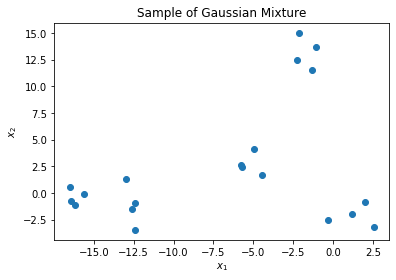

In [136]:
n_gaussians = 5
n_pts = 4
n = n_pts * n_gaussians
d = 2

data = gm(n_gaussians, n_pts, d, centroid_var=10)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()

# Standard Graph Spectral Clustering

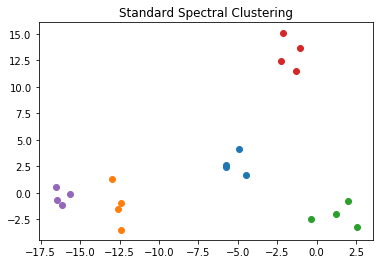

In [137]:
spectral = spectral_clustering(data, k=n_gaussians, lform="rw", metric = "g", s=1)
for i in range(len(spectral)):
    d = data[spectral == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)
plt.title("Standard Spectral Clustering")
plt.show()

# Hearing the Clusters

In [54]:
S = np.diag(np.ones(199), k=1) + np.diag(np.ones(199), k=-1)
S[100, 101] = 0.1
S[101, 100] = 0.1
L, deg = laplacian_matrix(S)
L_norm = (1/deg).reshape((-1, 1)) * L

k = 1
T_max = 10000
c = 1.41

# Debugging

In [55]:
n = len(L)

def dctmtx(n, normalize=False):
	d = sp.fftpack.dct(np.eye(n), axis=0)
	if(normalize):
		d = d / np.sqrt(np.sum(d**2, axis=1))
	return d

In [56]:
heat = np.zeros(shape = (n, T_max + 1))

M  = dctmtx(T_max+1, normalize=True)
            
heat[:, 0] = np.random.uniform(size = n)
heat[:, 1] = heat[:, 0] 

for i in range(2, T_max + 1): 
    heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (L_norm @ heat[:, i-1])
    heat_fft = np.fft.rfft(heat[1:], axis=1, norm="ortho")


#heat_fft = (heat - np.mean(heat, axis=1)[:, None]) @ M.T

# we've tried: rfft, fft, dct, multiplication by a DCT matrix
# observations: fft has a strange frequency gap, rfft seems closest to fig. 7
#
#
indices = [sp.signal.find_peaks(np.abs(heat_fft[idx]))[0][:k] for idx in range(n-1)]


binary = np.zeros(shape = (n, k))
for i in range(n-1):
    for j in range(k): 
        #if (M @ heat[i:i+1, :].T)[indices[i][j]] > 0:
        if( np.real( heat_fft[i, indices[i][j]] ) > 0 ):
            binary[i][j] = 1
        else:
            binary[i][j] = 0
cluster_num = [array_to_binary(binary[i]) for i in range(n)]

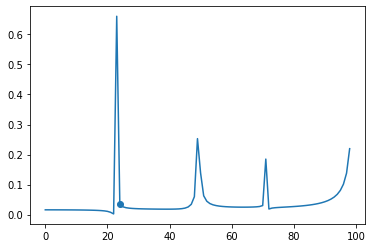

In [61]:
idx = 40
plt.plot(np.abs(heat_fft[idx, 1:100]))
plt.scatter(indices[idx], np.abs(heat_fft[idx, 1:100])[indices[idx]])
plt.show()

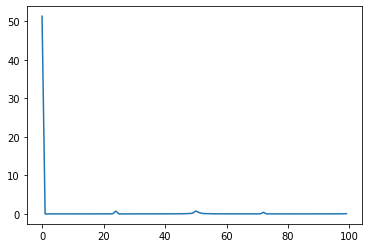

In [58]:
plt.plot(np.abs(heat_fft[20, :100]))

In [59]:
cluster_num

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0